In [ ]:
# Moving MNIST Dataset
# http://www.cs.toronto.edu/~nitish/unsupervised_video/

# Moving MNIST as PyTorch Dataset
# https://github.com/tychovdo/MovingMNIST/

from google.colab import files
src = list(files.upload().values())[0]

Saving MovingMNIST.py to MovingMNIST.py


In [ ]:
import torch
from torch import nn
from torchvision import transforms, datasets
import torch.utils.data as data

import os
import matplotlib.pyplot as plt
import numpy as np

import easydict
from tqdm.notebook import tqdm
from tqdm.notebook import trange

from __future__ import print_function
from PIL import Image
import os.path
import errno
import codecs

In [ ]:
from MovingMNIST import MovingMNIST

In [ ]:
train_data = MovingMNIST(root='.data/MNIST',
                         train = True, # Train True와 Train False의 차이.
                         split = 1000,
                         transform = transforms.ToTensor(),
                         target_transform = transforms.ToTensor(),
                         download = True)

Processing...
Done!


In [ ]:
test_data = MovingMNIST(root='.data/MNIST',
                        train = False,
                        split = 1000,
                        transform = transforms.ToTensor(),
                        target_transform = transforms.ToTensor(),
                        download = True)

In [ ]:
# Data VIsualization : train_data

def imshow(data, title):
    num = len(data)
    fig = plt.figure(figsize=(5 * num, 5))
    
    for i in range(1, num + 1):
        a = fig.add_subplot(1, num + 1, i)
        a.imshow(data[i-1])
    plt.suptitle(title, fontsize=30)

# Tuple 형태의 dataset
# past data 10개, future data 10개로 구성되어 있음.

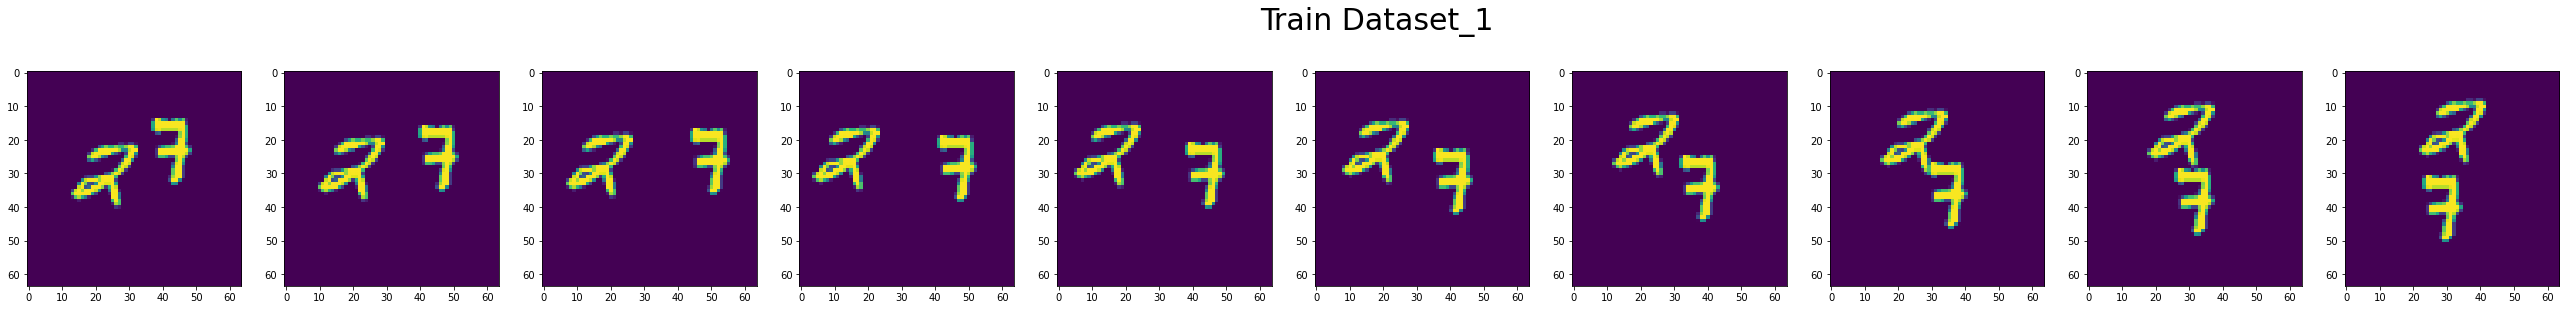

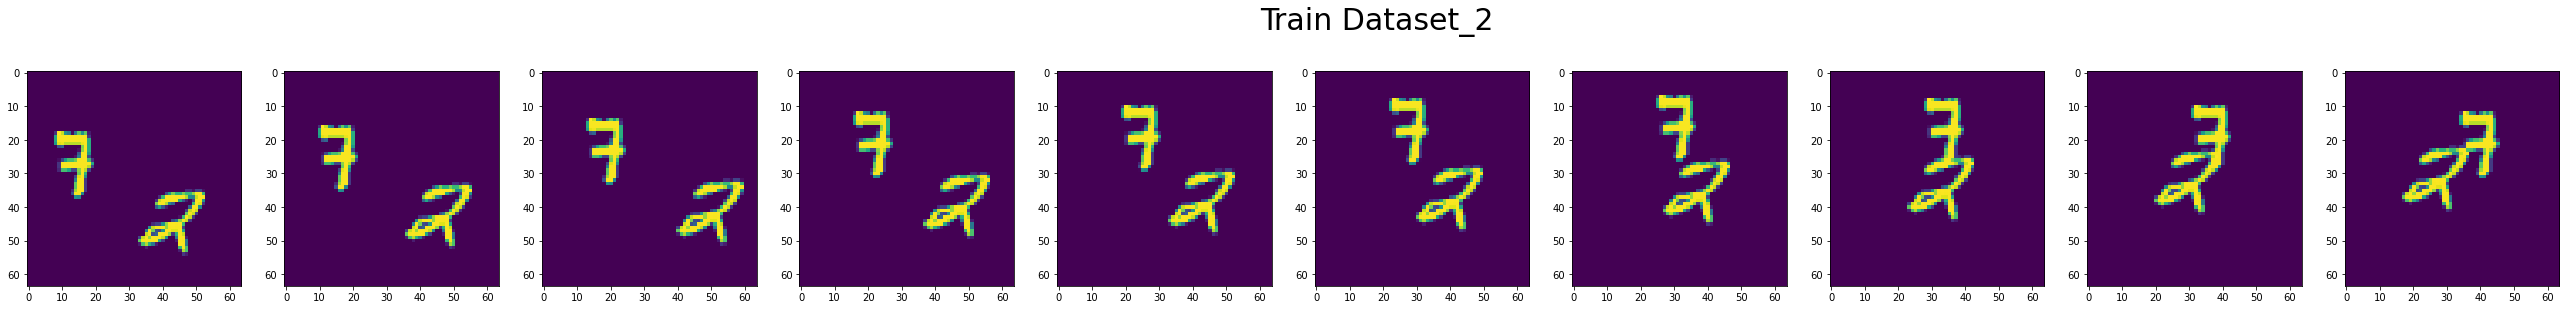

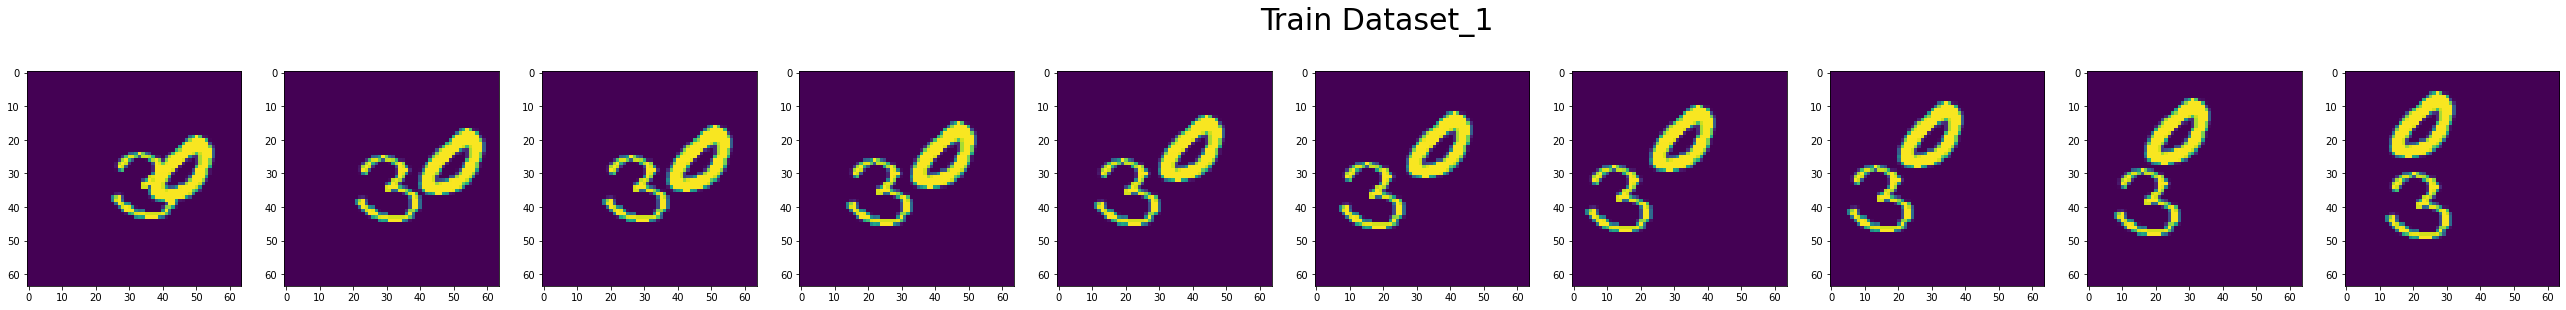

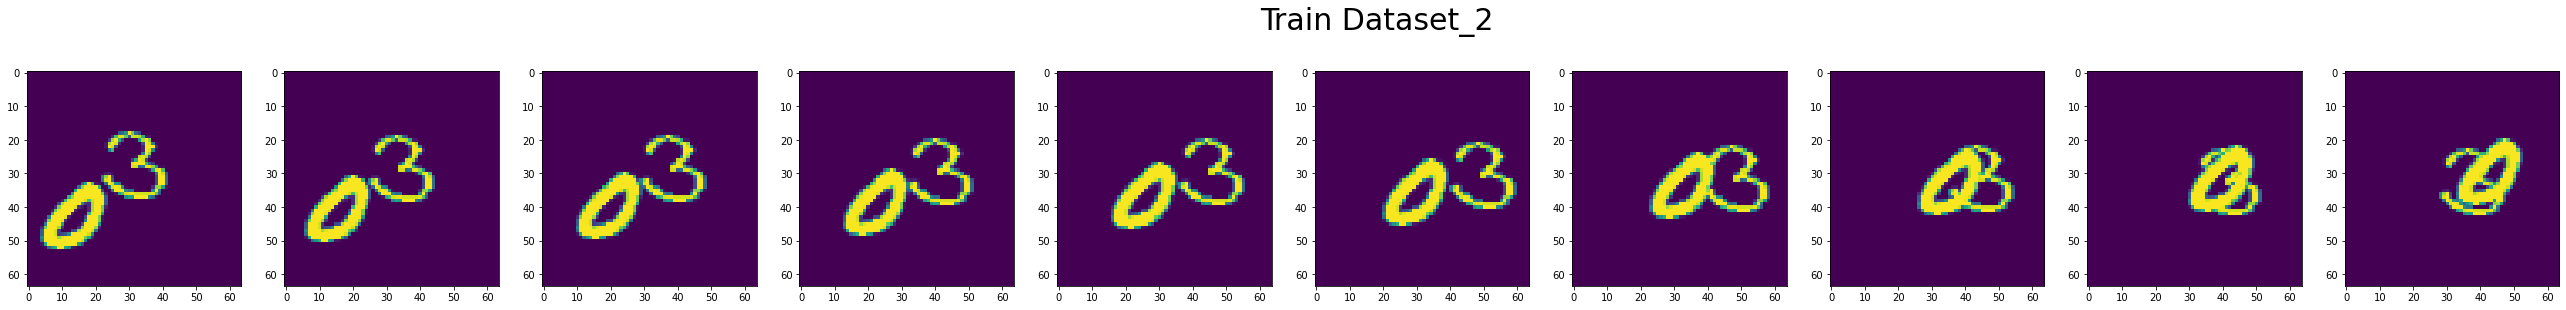

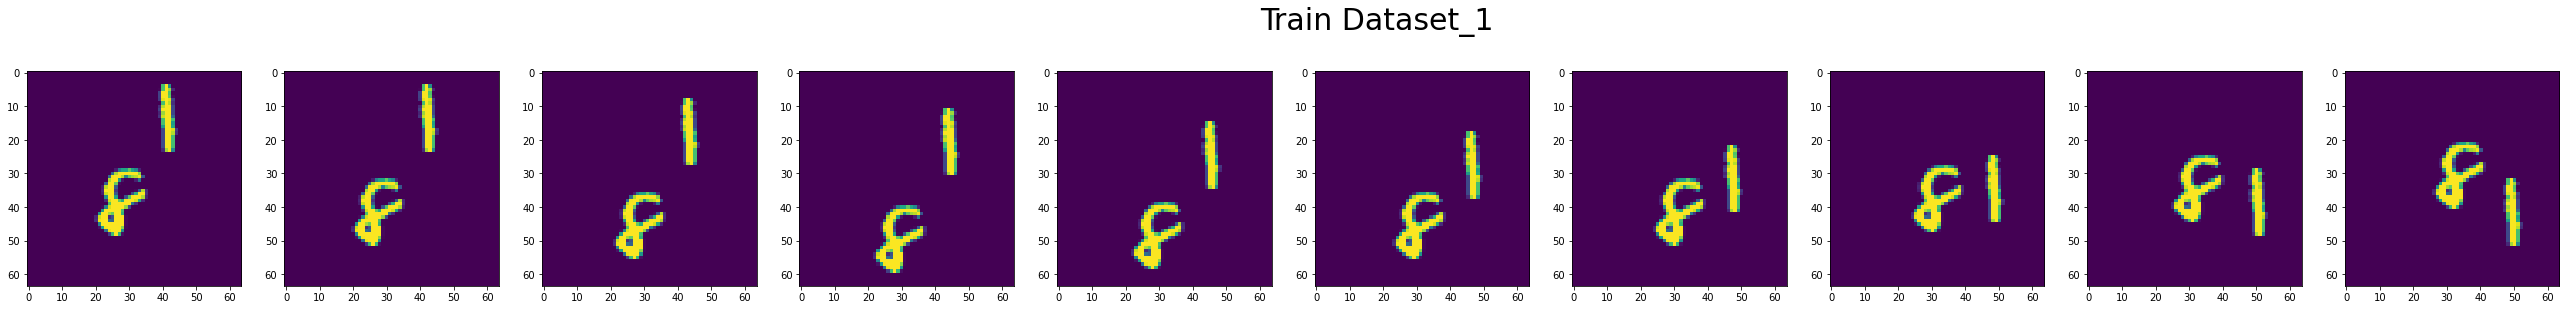

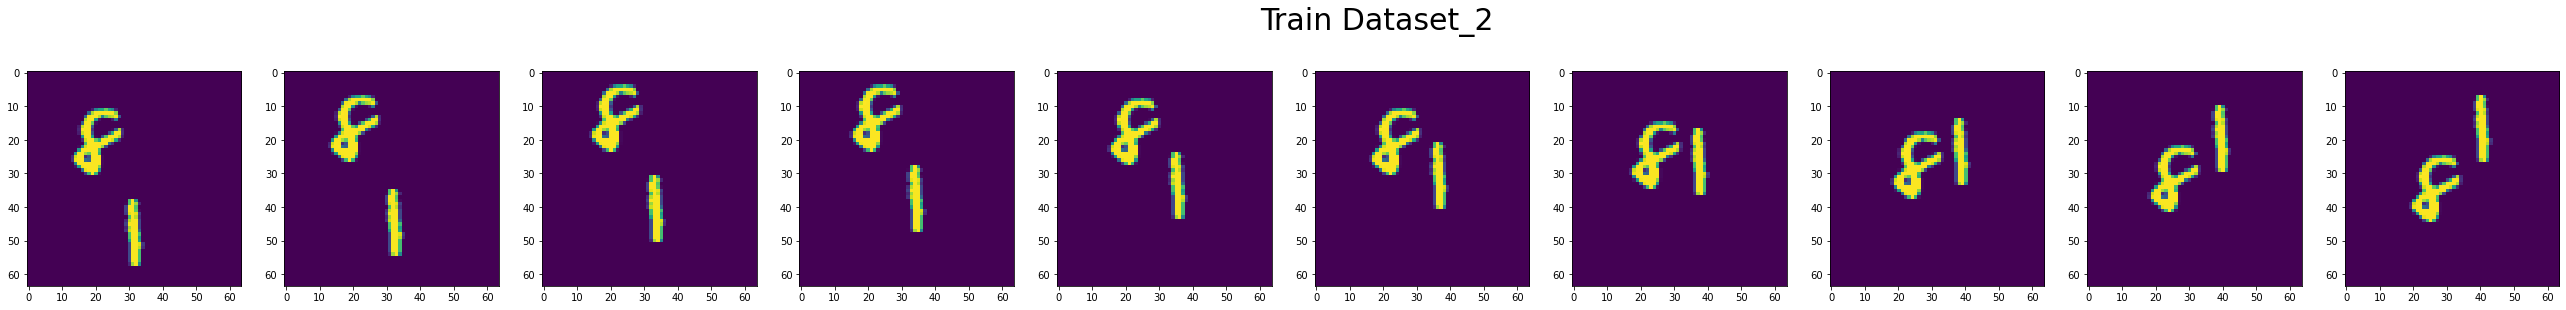

In [ ]:
for i in range(0, 3):
  data_1, data_2 = train_data[i]
  imshow(data_1, title='Train Dataset_1')
  imshow(data_2, title='Train Dataset_2')

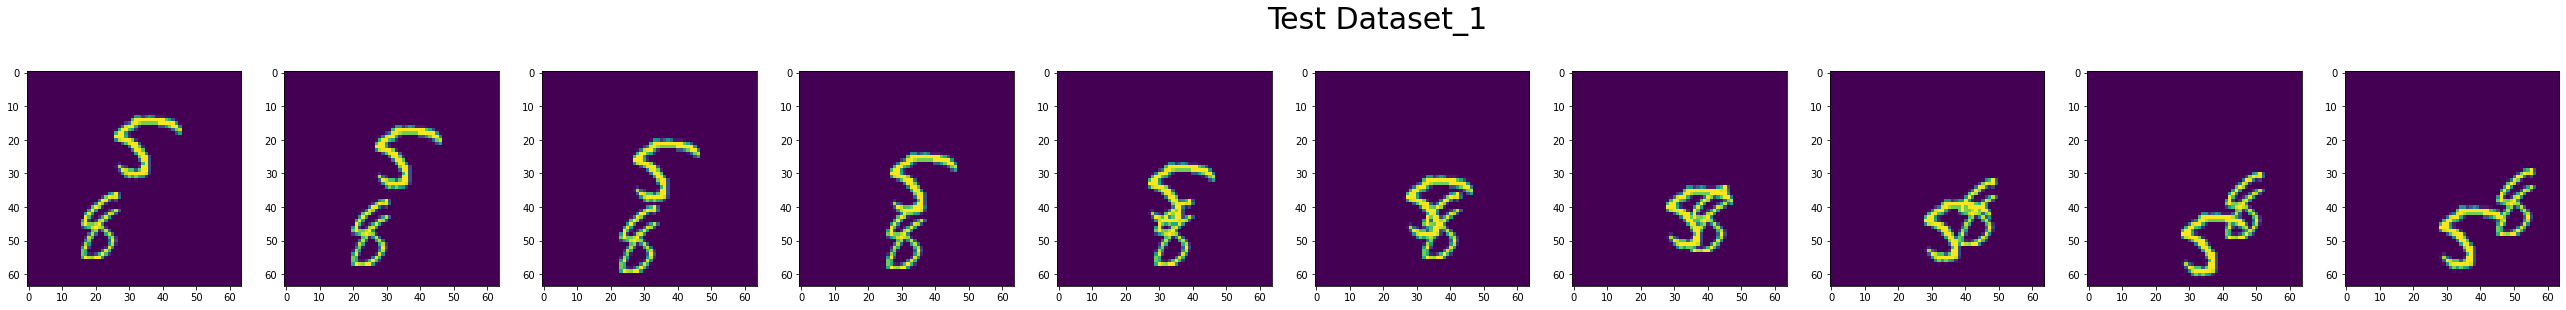

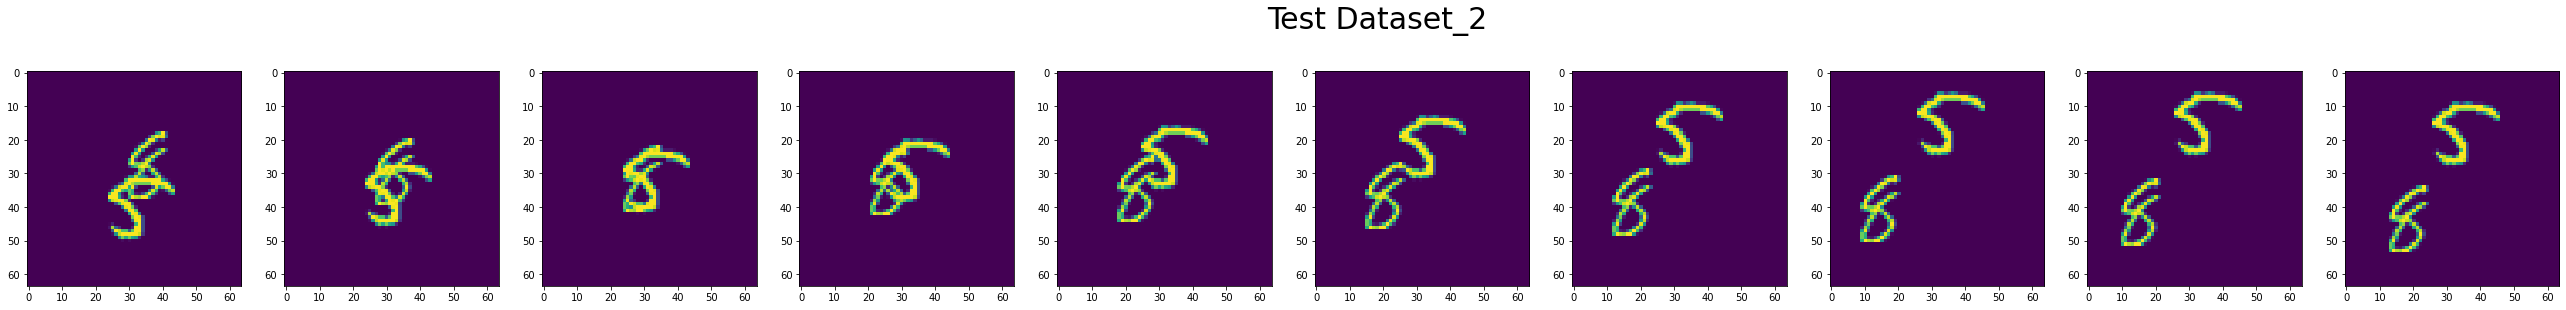

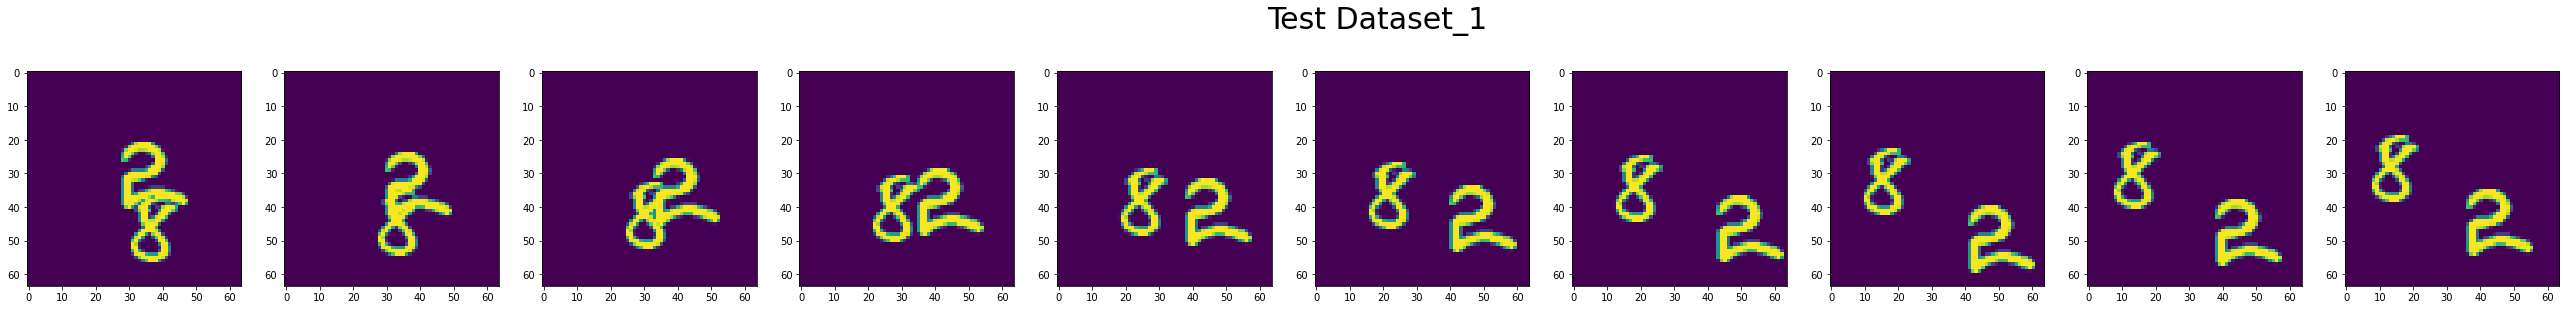

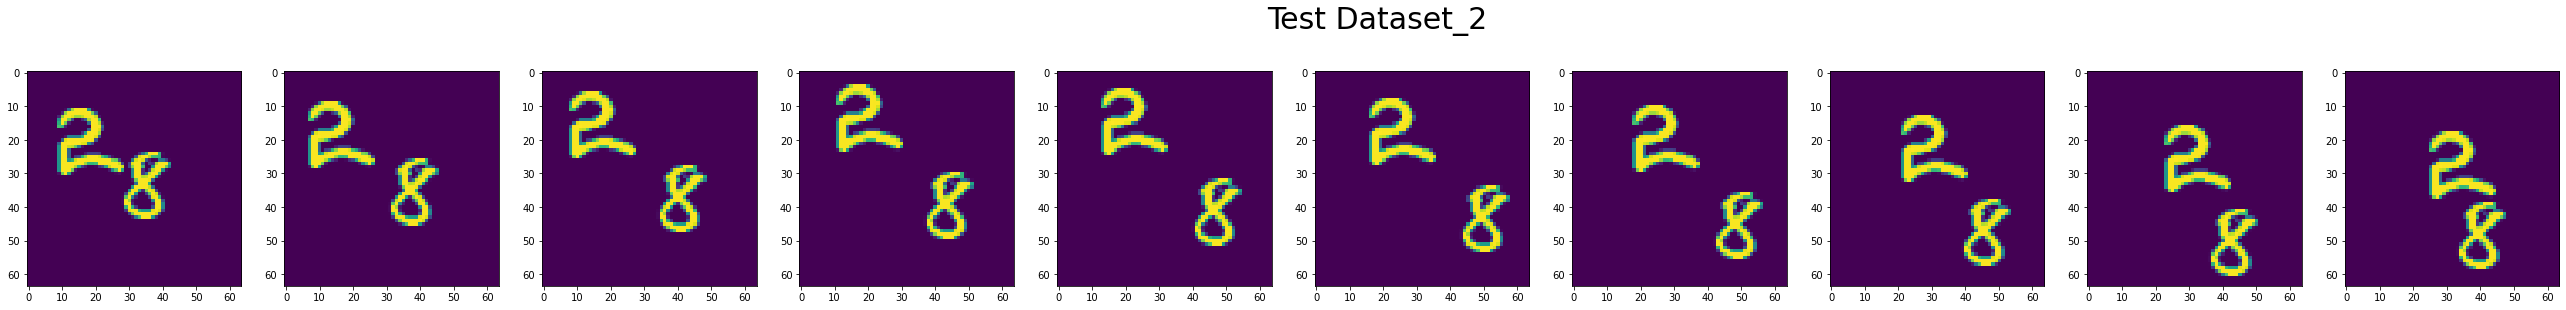

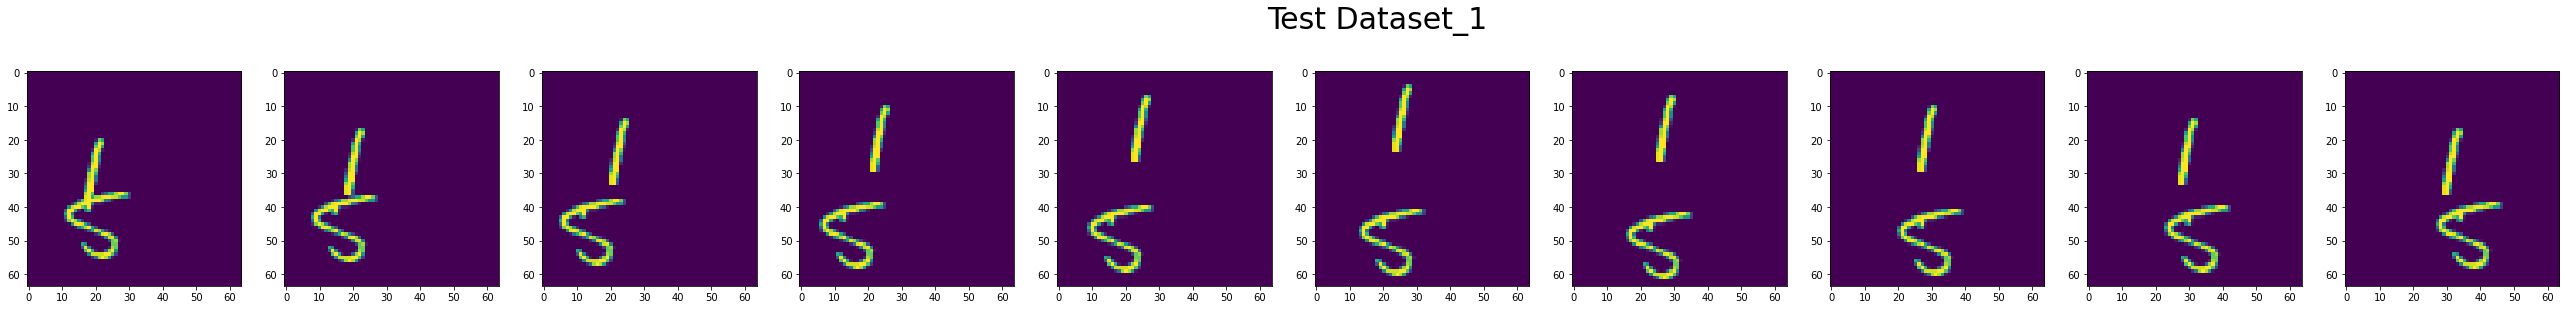

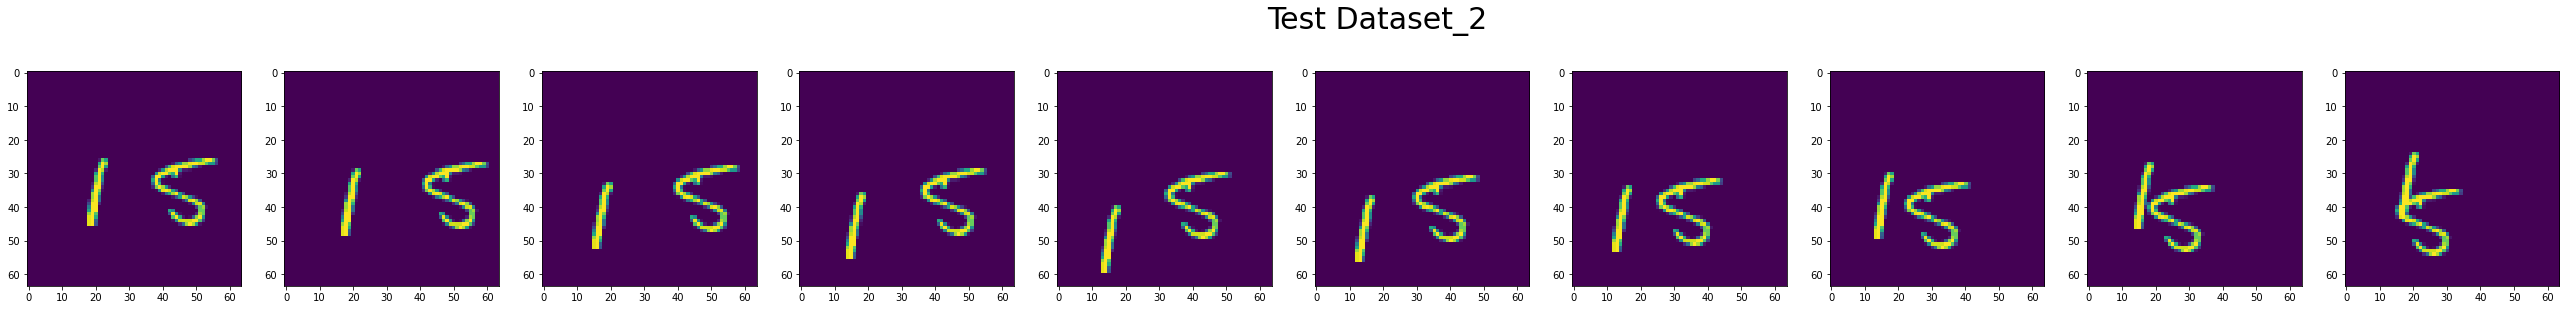

In [ ]:
# Data VIsualization : test_data

for i in range(0, 3):
  data_1, data_2 = test_data[i]
  imshow(data_1, title='Test Dataset_1')
  imshow(data_2, title='Test Dataset_2')

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size=4096, hidden_size=1024, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, 
                            hidden_size, 
                            num_layers, 
                            batch_first=True, 
                            dropout=0.1, 
                            bidirectional=False)

    def forward(self, x):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        outputs, (hidden, cell) = self.lstm(x)
        return (hidden, cell)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_size=4096, hidden_size=1024, output_size=4096, num_layers=2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, 
                            hidden_size, 
                            num_layers, 
                            batch_first=True,
                            dropout=0.1, 
                            bidirectional=False)        
        self.fc = nn.Linear(hidden_size, output_size)
        # Encoder이랑 똑같이 LSTM까지 구성하나, 여기는 Decoder이므로 마지막에 Fully Connected Layer를 추가해준다.
   
    def forward(self, x, hidden):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        output, (hidden, cell) = self.lstm(x, hidden)
        prediction = self.fc(output)
        return prediction, (hidden, cell)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, args):
        super().__init__()
        
        hidden_size = args.hidden_size
        input_size = args.input_size
        output_size = args.output_size
        num_layers = args.num_layers
        
        self.encoder = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        self.reconstruct_decoder = Decoder(
            input_size=input_size,
            output_size=output_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        
        self.predict_decoder = Decoder(
            input_size=input_size,
            output_size=output_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        
        self.criterion = nn.MSELoss()
    
    ## Loss 출력
    def forward(self, src, trg):
        # src: tensor of shape (batch_size, seq_length, hidden_size)
        # trg: tensor of shape (batch_size, seq_length, hidden_size)

        batch_size, sequence_length, img_size = src.size()
        
        ## Encoder 넣기
        encoder_hidden = self.encoder(src)
        
        ## Prediction Loss 계산 
        predict_output = []
        temp_input = torch.zeros((batch_size,1,img_size), dtype=torch.float).to(src.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            temp_input, hidden = self.predict_decoder(temp_input, hidden)
            predict_output.append(temp_input)
            
        predict_output = torch.cat(predict_output, dim=1)
        predict_loss = self.criterion(predict_output, trg)
        
        ## Reconstruction Loss 계산
        inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
        reconstruct_output = []
        temp_input = torch.zeros((batch_size,1,img_size), dtype=torch.float).to(src.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            reconstruct_output.append(temp_input)
        reconstruct_output = torch.cat(reconstruct_output, dim=1)
        reconstruct_loss = self.criterion(reconstruct_output, src[:, inv_idx, :])
            
        return reconstruct_loss, predict_loss
    
    ## 이미지 생성(Prediction)
    def generate(self, src):
        batch_size, sequence_length, img_size = src.size()
        
        ## Encoder 넣기
        hidden = self.encoder(src)
        
        outputs = []
        temp_input = torch.zeros((batch_size,1,img_size), dtype=torch.float).to(src.device)
        for t in range(sequence_length):
            temp_input, hidden = self.predict_decoder(temp_input, hidden)
            outputs.append(temp_input)
        
        return torch.cat(outputs, dim=1)
    
    ## 이미지 복구(Reconstruction) 
    def reconstruct(self, src):
        batch_size, sequence_length, img_size = src.size()
        
        ## Encoder 넣기
        hidden = self.encoder(src)
        
        outputs = []
        temp_input = torch.zeros((batch_size,1,img_size), dtype=torch.float).to(src.device)
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            outputs.append(temp_input)
        
        return torch.cat(outputs, dim=1)

In [ ]:
def run(args, model, train_loader, test_loader):
    # optimizer 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    ## 반복 횟수 Setting
    epochs = tqdm(range(args.max_iter//len(train_loader)+1))
    
    ## 학습하기
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training")

        for i, batch_data in train_iterator:
            
            if count > args.max_iter:
                return model
            count += 1
            
            future_data, past_data = batch_data

            ## 데이터 GPU 설정 및 사이즈 조절
            batch_size = past_data.size(0)
            example_size = past_data.size(1)
            past_data = past_data.view(batch_size, example_size, -1).float().to(args.device)
            future_data = future_data.view(batch_size, example_size, -1).float().to(args.device)

            reconstruct_loss, predict_loss = model(past_data, future_data)

            ## Composite Loss
            loss = reconstruct_loss + predict_loss

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_iterator.set_postfix({
                "train_loss": float(loss),
            })

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
        with torch.no_grad():
            for i, batch_data in test_iterator:
                future_data, past_data = batch_data

                ## 데이터 GPU 설정 및 사이즈 조절
                batch_size = past_data.size(0)
                example_size = past_data.size(1)
                past_data = past_data.view(batch_size, example_size, -1).float().to(args.device)
                future_data = future_data.view(batch_size, example_size, -1).float().to(args.device)

                reconstruct_loss, predict_loss = model(past_data, future_data)

                ## Composite Loss
                loss = reconstruct_loss + predict_loss

                eval_loss += loss.mean().item()

                test_iterator.set_postfix({
                    "eval_loss": float(loss),
                })
        eval_loss = eval_loss / len(test_loader)
        print("Evaluation Score : [{}]".format(eval_loss))
    return model

In [ ]:
args = easydict.EasyDict({
    "batch_size": 128, ## 배치 사이즈 설정
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), ## GPU 사용 여부 설정
    "input_size": 4096, ## 입력 차원 설정
    "hidden_size": 2048, ## Hidden 차원 설정
    "output_size": 4096, ## 출력 차원 설정
    "num_layers": 2,     ## LSTM layer 갯수 설정
    "learning_rate" : 0.0005, ## learning rate 설정
    "max_iter" : 1000, ## 총 반복 횟수 설정
})

In [ ]:
train_loader = torch.utils.data.DataLoader(
                 dataset=train_data,
                 batch_size=args.batch_size,
                 shuffle=True)

In [ ]:
test_loader = torch.utils.data.DataLoader(
                dataset=test_data,
                batch_size=args.batch_size,
                shuffle=False)

In [ ]:
model = Seq2Seq(args)
model.to(args.device)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(4096, 2048, num_layers=2, batch_first=True, dropout=0.1)
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(4096, 2048, num_layers=2, batch_first=True, dropout=0.1)
    (fc): Linear(in_features=2048, out_features=4096, bias=True)
  )
  (predict_decoder): Decoder(
    (lstm): LSTM(4096, 2048, num_layers=2, batch_first=True, dropout=0.1)
    (fc): Linear(in_features=2048, out_features=4096, bias=True)
  )
  (criterion): MSELoss()
)

In [ ]:
model = run(args, model, train_loader, test_loader)

save_path = 'result'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
model_path = os.path.join(save_path, 'model.bin')    
torch.save(model.state_dict(), model_path)


Evaluation Score : [0.06533689703792334]



Evaluation Score : [0.059473562985658646]



Evaluation Score : [0.05643098521977663]



Evaluation Score : [0.05438269209116697]



Evaluation Score : [0.05330616747960448]



Evaluation Score : [0.05243142694234848]



Evaluation Score : [0.051602423656731844]



Evaluation Score : [0.050858286675065756]



Evaluation Score : [0.050180704798549414]



Evaluation Score : [0.04970812797546387]



Evaluation Score : [0.04896555934101343]



Evaluation Score : [0.04861480323597789]



Evaluation Score : [0.048184087965637445]



Evaluation Score : [0.047755425330251455]


In [ ]:
pip install celluloid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and wil

CalledProcessError: ignored

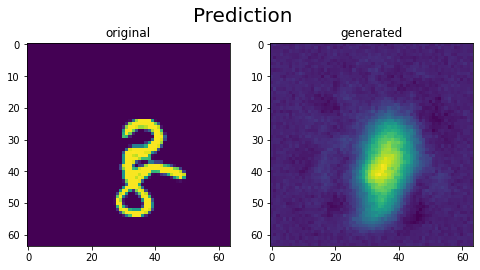

In [ ]:
from celluloid import Camera

# 에니메이션 데이터 시각화
def animation_show(original_data, generated_data, title, save_path):
    fig = plt.figure(figsize=(8, 4))
    camera = Camera(fig)
    for i in range(len(original_data)):
        ax=fig.add_subplot(121)
        ax.imshow(original_data[i])
        ax.set_title('original')
        ax2=fig.add_subplot(122)
        ax2.imshow(generated_data[i])
        ax2.set_title('generated')
        plt.suptitle(title, fontsize=20)
        camera.snap()
    
    animation = camera.animate(500, blit=True)
    
    # .gif 파일로 저장하면 끝!
    animation.save(
        save_path,
        dpi=300,
        savefig_kwargs={
            'frameon': False,
            'pad_inches': 'tight'
        }
    )

# 결과 출력
future_data, past_data = test_data[1]
model.eval()
with torch.no_grad():
    future_data = future_data.to(args.device).view(1, 10, -1).float()
    past_data = past_data.to(args.device).view(1, 10, -1).float()
    outputs = model.generate(past_data)

original_data = future_data.reshape(-1, 64, 64).cpu().squeeze().numpy()
generated_data = outputs.reshape(-1, 64, 64).cpu().squeeze().numpy()

animation_show(original_data, generated_data, "Prediction", 'prediction.gif')

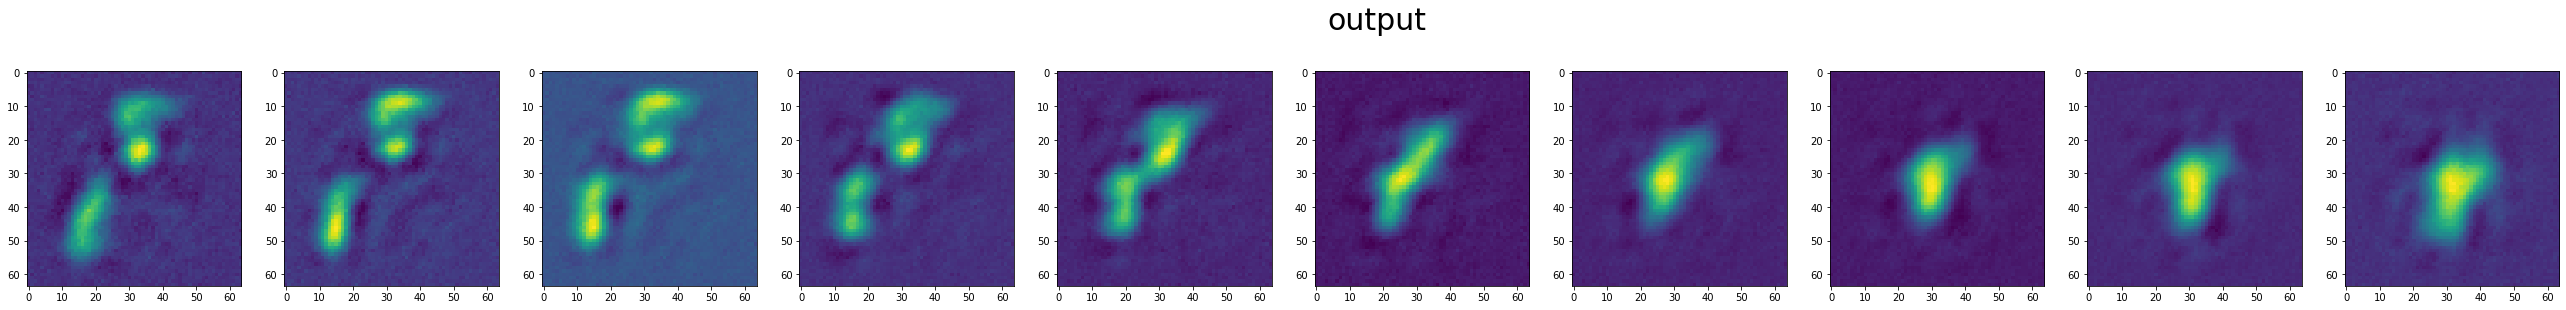

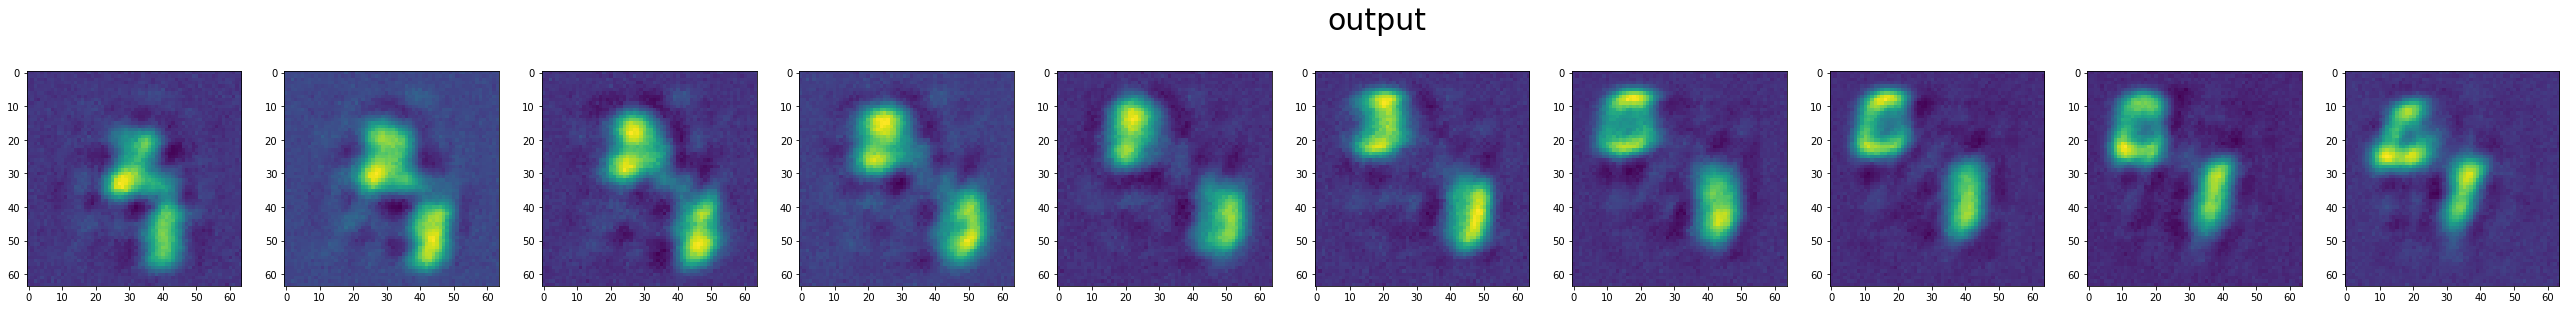

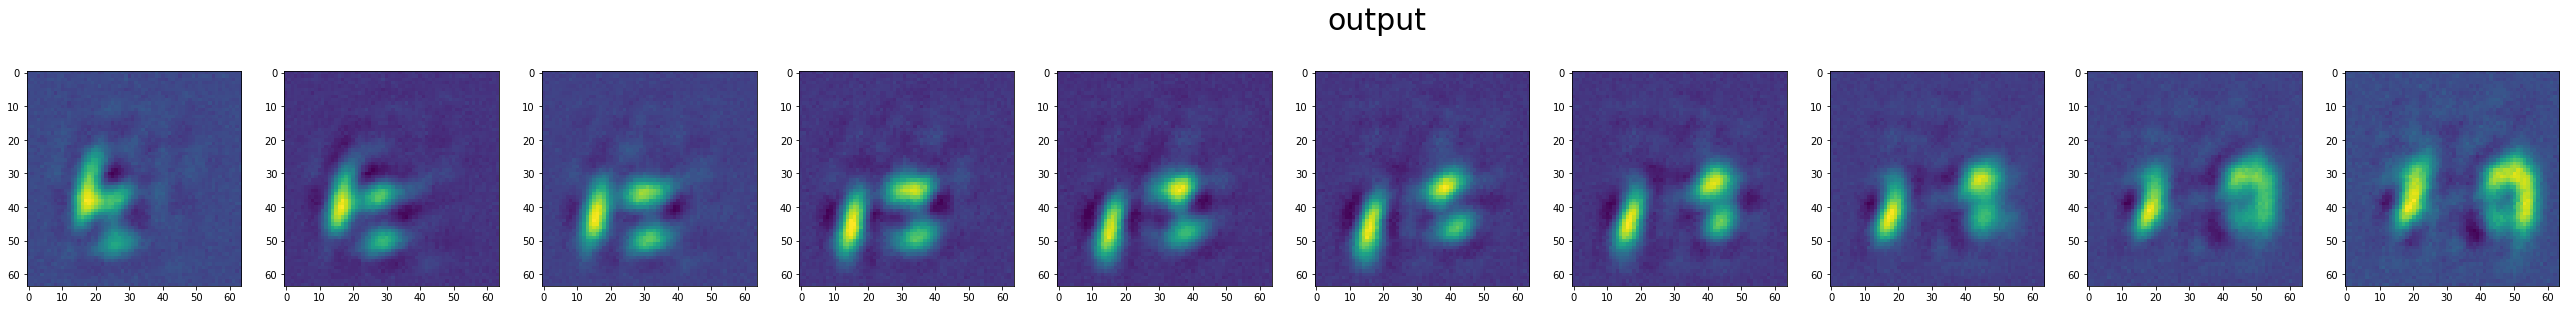

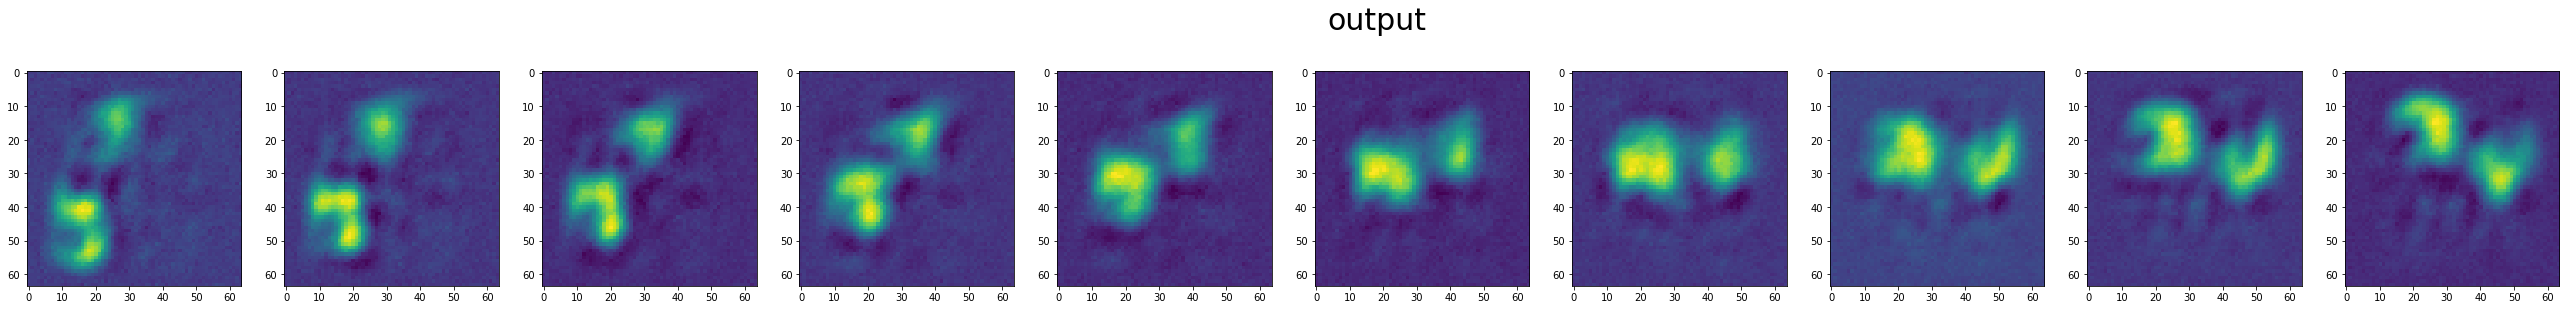

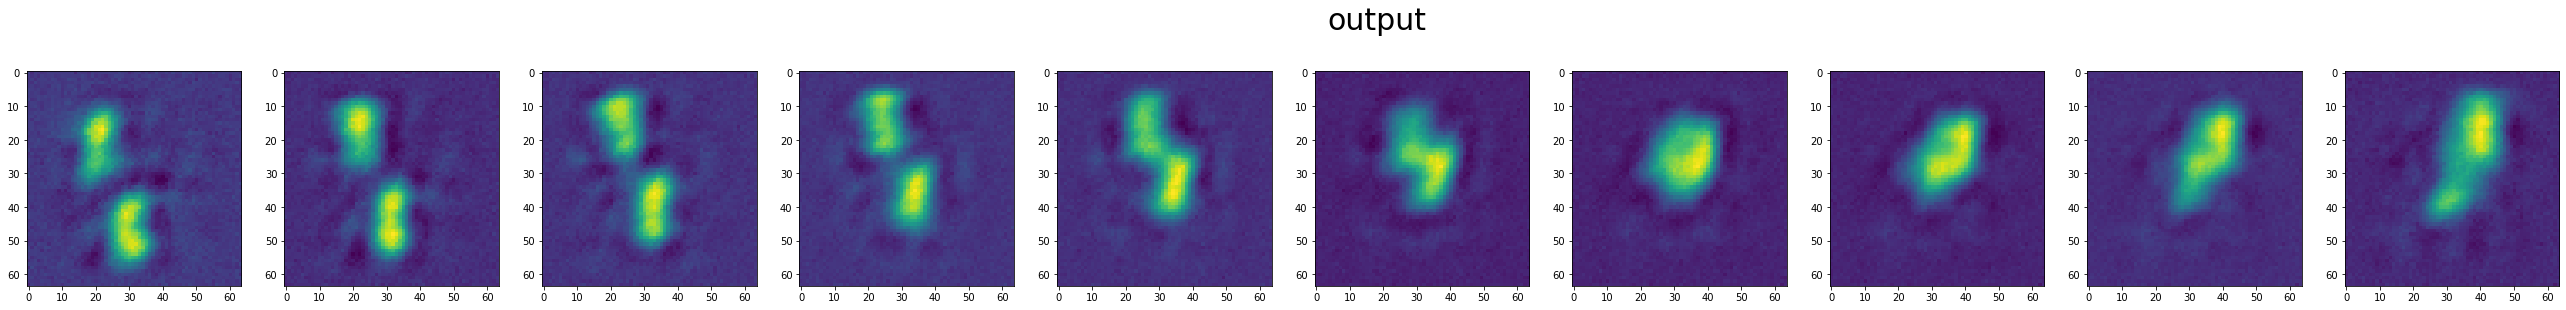

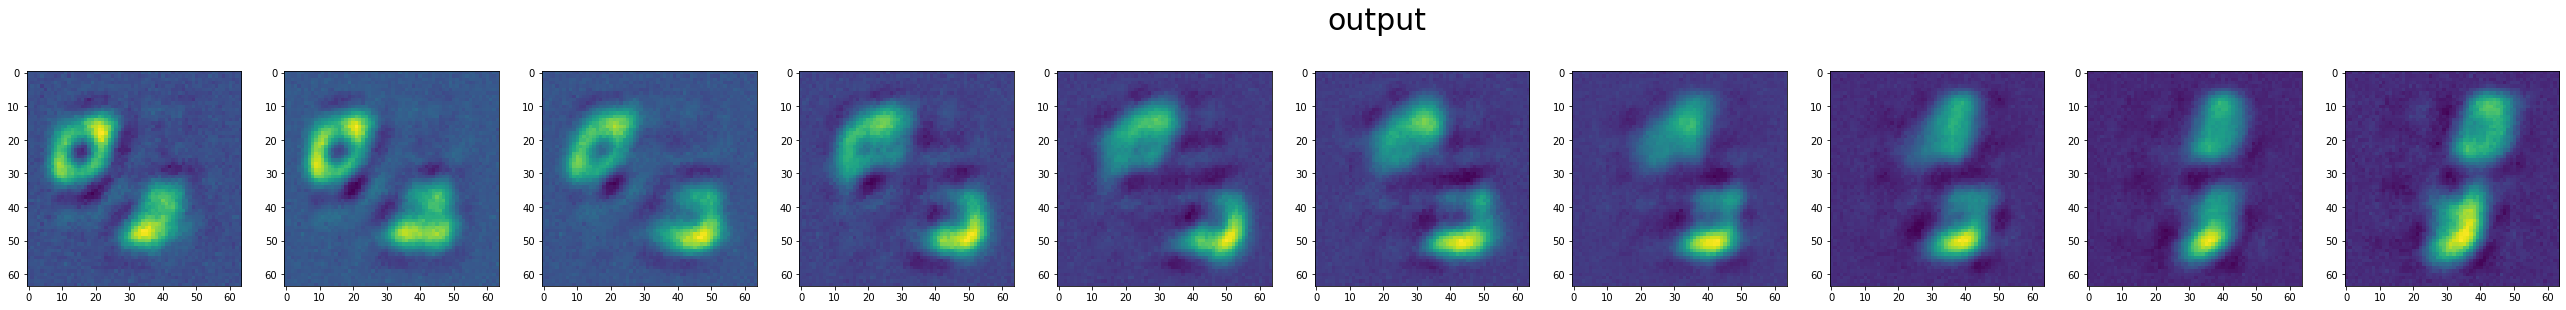

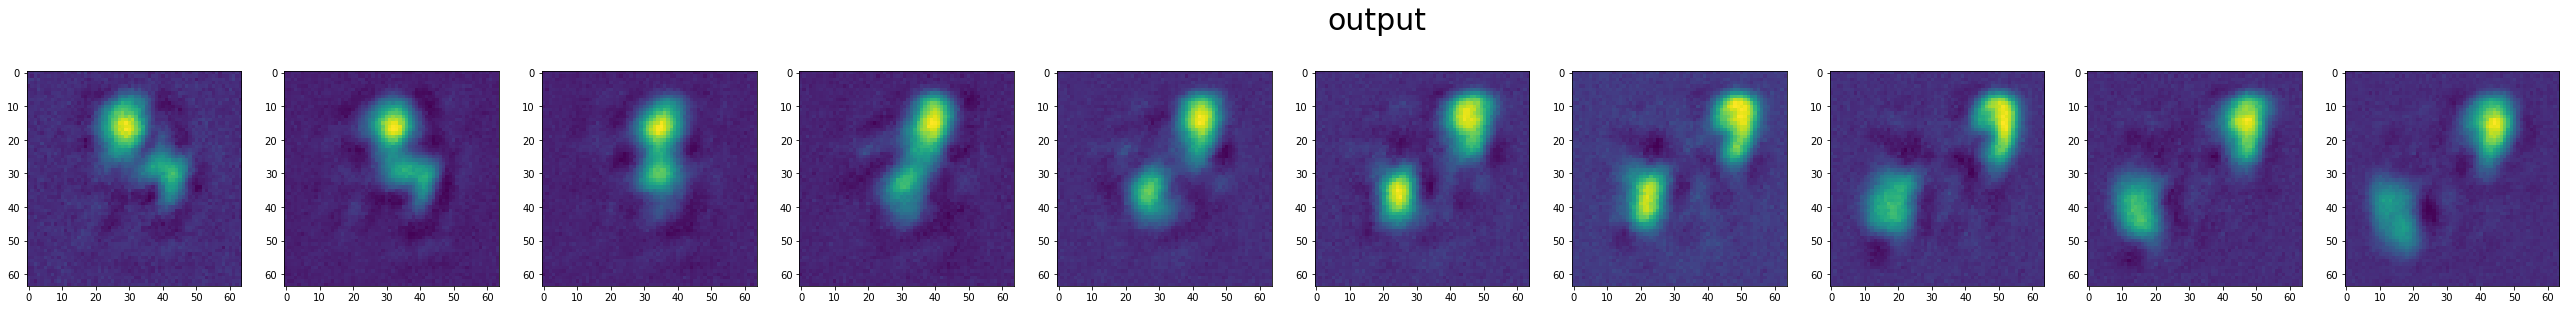

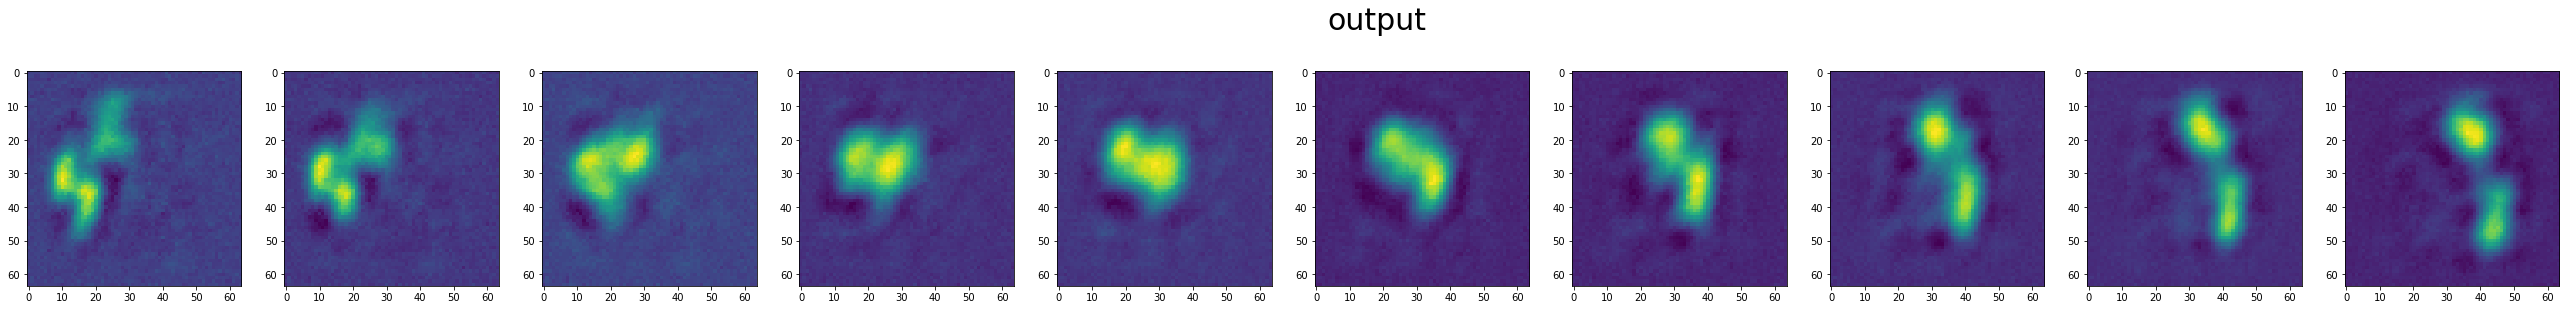

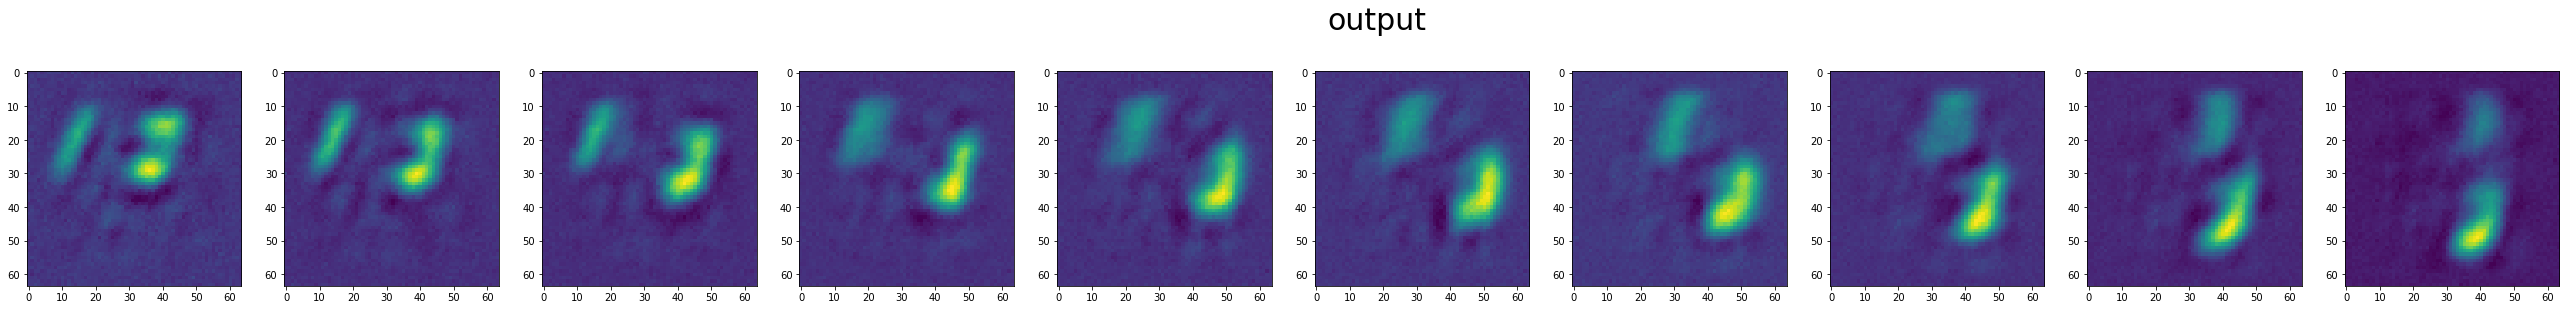

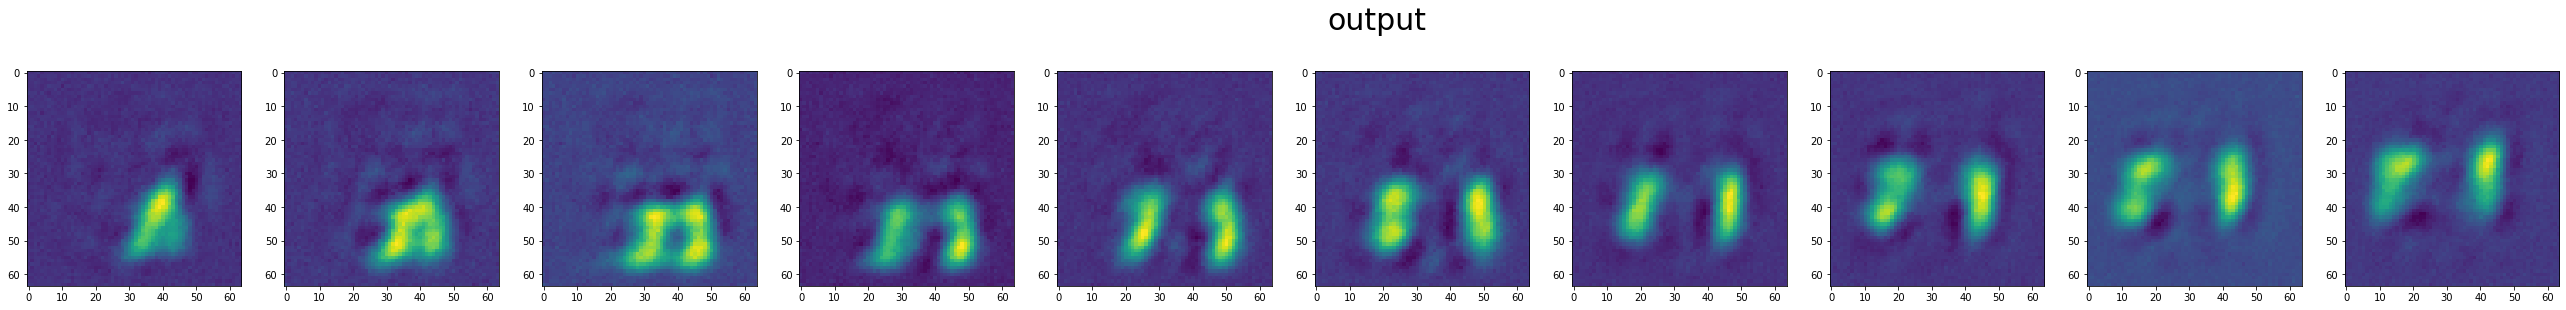

In [ ]:
for i in range(0, 10):
  future_data, past_data = test_data[i]
  model.eval()
  with torch.no_grad():
      future_data = future_data.to(args.device).view(1, 10, -1).float()
      past_data = past_data.to(args.device).view(1, 10, -1).float()
      outputs = model.reconstruct(past_data)
  imshow(outputs.reshape(-1, 64, 64).cpu().squeeze().numpy(), title='output')